In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# torch.autograd.set_detect_anomaly(True)

states = torch.tensor([0, 1, 2])
Transition = torch.tensor([[0, 1/2, 1/2],
                           [1/2, 0, 1/2],
                           [1/2, 1/2, 0]])
obs = torch.tensor([0, 0, 2, 1, 1, 2])
Observation = torch.tensor([[1/2, 0, 1/3, 1/2],
                            [1/2, 1/2, 1/3, 1/2],
                            [0, 1/2, 1/3, 0]])
Duration = torch.tensor([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]])

tensor([[0.5000, 0.5000, 0.3333, 0.0000, 0.0000, 0.3333],
        [0.5000, 0.5000, 0.3333, 0.5000, 0.5000, 0.3333],
        [0.0000, 0.0000, 0.3333, 0.5000, 0.5000, 0.3333]], requires_grad=True)


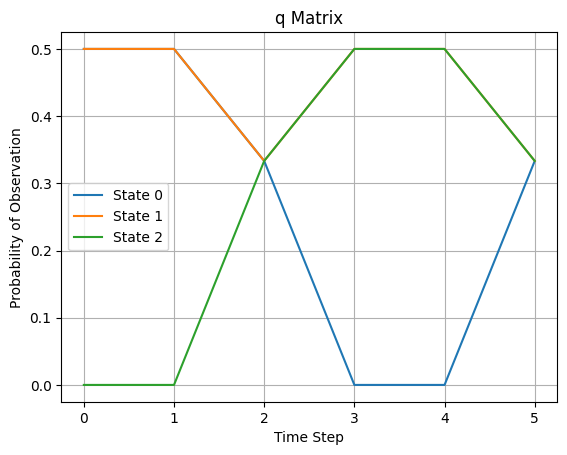

In [32]:
def q_matrix(obs, Observation):
    return Observation[:, obs].clone().detach().requires_grad_(True)

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(len(obs))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(obs))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
def matrix_mult_factor(log_alpha_row, Transition):
    alpha_row = torch.exp(log_alpha_row)
    product = alpha_row @ Transition
    factor = torch.sum(product)
    return torch.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    result = torch.exp(log_alpha_row)@Transition
    if torch.sum(result) != 0:
        return torch.log(result / torch.sum(result))
    else:
        return torch.zeros_like(result)

In [55]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_alpha = torch.full((T, N), -float('inf'))
    start = torch.tensor([1/3, 1/3, 1/3])

    # initialization
    for t in range(D):
        new_log_alpha = torch.log(start) + torch.log(Duration[:, t]) + torch.sum(torch.log(q[:, :t+1]), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1))
        log_alpha[t] = new_log_alpha
    
    # fill log_alpha[D:]
    for t in range(D, T):
        new_log_alpha = log_alpha[t]
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            print("new_log_alpha:", new_log_alpha)
            print("factor:", factor)
            print("vector:", vector)
            print("Duration[:, d]:", Duration[:, d])
            print("torch.sum(torch.log(q[:, t-d:t+1])):", torch.sum(torch.log(q[:, t-d:t+1])))

            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1))
        log_alpha[t] = new_log_alpha

    log_alpha_sum = torch.sum(log_alpha)
    log_alpha_sum.backward()
    print(q.grad)
    
    return torch.exp(log_alpha)


fwd = forward(states, Transition, obs, q, Duration).detach().numpy()
print(fwd)

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(obs))]
    plt.plot(time_steps, probs, label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

new_log_alpha: tensor([-inf, -inf, -inf], grad_fn=<SelectBackward0>)
factor: tensor([[-3.5835, -3.5835, -3.5835]], grad_fn=<CatBackward0>)
vector: tensor([-1.3863, -1.3863, -0.6931], grad_fn=<LogBackward0>)
Duration[:, d]: tensor([1, 0, 0])
torch.sum(torch.log(q[:, t-d:t+1])): tensor(-inf, grad_fn=<SumBackward0>)
new_log_alpha: tensor([[-inf, -inf, -inf]], grad_fn=<LogaddexpBackward0>)
factor: tensor([[-2.4849, -2.4849, -2.4849]], grad_fn=<CatBackward0>)
vector: tensor([-0.6931,    -inf, -0.6931], grad_fn=<LogBackward0>)
Duration[:, d]: tensor([0, 1, 0])
torch.sum(torch.log(q[:, t-d:t+1])): tensor(-inf, grad_fn=<SumBackward0>)
new_log_alpha: tensor([[-inf, -inf, -inf]], grad_fn=<LogaddexpBackward0>)
factor: tensor([[-1.7918, -1.7918, -1.7918]], grad_fn=<CatBackward0>)
vector: tensor([   -inf, -0.6931, -0.6931], grad_fn=<LogBackward0>)
Duration[:, d]: tensor([0, 0, 1])
torch.sum(torch.log(q[:, t-d:t+1])): tensor(-inf, grad_fn=<SumBackward0>)
new_log_alpha: tensor([-inf, -inf, -inf], gra

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in LogaddexpBackward0. Traceback of forward call that caused the error:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelapp.py", line 724, in start
    self.io_loop.start()
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-p

RuntimeError: Function 'LogaddexpBackward0' returned nan values in its 0th output.

[[0.16666666 0.         0.        ]
 [0.         0.08333333 0.        ]
 [0.01388889 0.01388889 0.        ]
 [0.         0.         0.        ]
 [0.         0.00173611 0.00347222]
 [0.00086806 0.         0.00115741]]


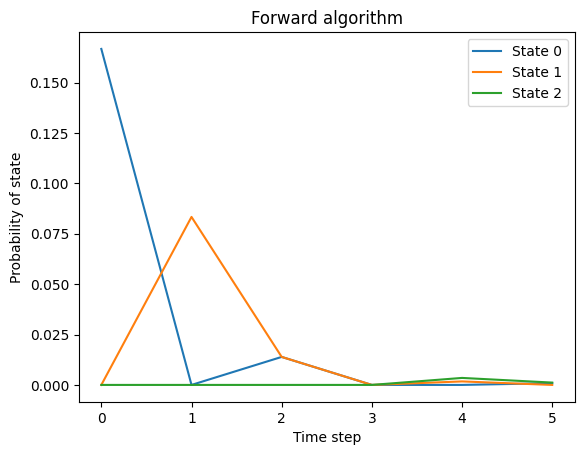

In [48]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_alpha = torch.full((T, N), -float('inf'))
    start = torch.tensor([1/3, 1/3, 1/3])

    # initialization
    for t in range(D):
        log_alpha[t] = torch.log(start) + torch.log(Duration[:, t]) + torch.sum(torch.log(q[:, :t+1]), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            log_alpha[t] = torch.logaddexp(log_alpha[t], factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1))
    
    # fill log_alpha[D:]
    for t in range(D, T):
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            log_alpha[t] = torch.logaddexp(log_alpha[t], factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1))
    
    return torch.exp(log_alpha)

fwd = forward(states, Transition, obs, q, Duration).detach().numpy()
print(fwd)

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(obs))]
    plt.plot(time_steps, probs, label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

In [59]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_beta = torch.full((T, N), -float('inf'))

    # initialization, log_beta[-1]
    log_beta_new = log_beta.clone()
    log_beta_new[-1] = torch.zeros(N)
    log_beta = log_beta_new
    
    # fill log_beta[:-1]
    for t in range(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta_new = log_beta.clone()
                log_beta_new[t] = torch.logaddexp(log_beta[t], torch.logsumexp(torch.row_stack([log_beta[t+d+1]]*N) + torch.log(Transition) + torch.log(torch.row_stack([Duration[:, d]]*N)) + torch.sum(torch.log(q[:, t + 1:t + d + 2]), axis=1), axis=1))
                log_beta = log_beta_new

    log_beta_sum = torch.sum(log_beta)
    log_beta_sum.backward()
    print(q.grad)

    return torch.exp(log_beta)


bwd = backward(states, Transition, obs, q, Duration).detach().numpy()
print(bwd)

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(obs))]
    plt.plot(range(len(obs)), probs, label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in LogsumexpBackward0. Traceback of forward call that caused the error:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelapp.py", line 724, in start
    self.io_loop.start()
  File "/Users/jingcao/Library/Python/3.10/lib/python/site-p

RuntimeError: Function 'LogsumexpBackward0' returned nan values in its 0th output.

[[0.00347222 0.00173611 0.00520833]
 [0.00694444 0.01736111 0.01041667]
 [0.0625     0.04166666 0.02083333]
 [0.08333333 0.         0.08333333]
 [0.         0.16666666 0.16666666]
 [1.         1.         1.        ]]


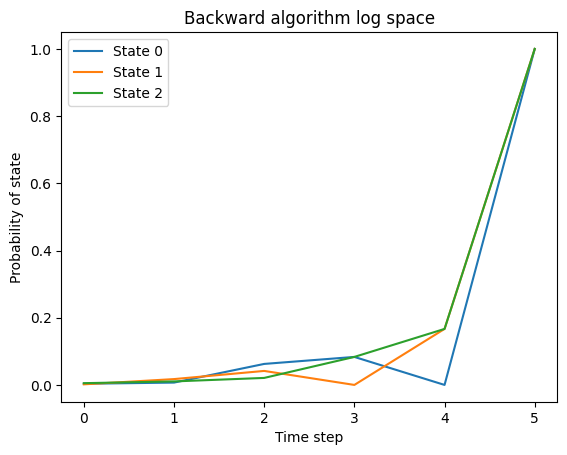

In [56]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_beta = torch.full((T, N), -float('inf'))

    # initialization, log_beta[-1]
    log_beta[-1] = torch.zeros(N)
    
    # fill log_beta[:-1]
    for t in range(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta[t] = torch.logaddexp(log_beta[t], torch.logsumexp(torch.row_stack([log_beta[t+d+1]]*N) + torch.log(Transition) + torch.log(torch.row_stack([Duration[:, d]]*N)) + torch.sum(torch.log(q[:, t + 1:t + d + 2]), axis=1), axis=1))

    return torch.exp(log_beta)

bwd = backward(states, Transition, obs, q, Duration).detach().numpy()
print(bwd)

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(obs))]
    plt.plot(range(len(obs)), probs, label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

None
[[0.2857143  0.         0.        ]
 [0.         0.71428573 0.        ]
 [0.42857146 0.2857143  0.        ]
 [0.         0.         0.        ]
 [0.         0.14285715 0.2857143 ]
 [0.42857146 0.         0.5714286 ]]


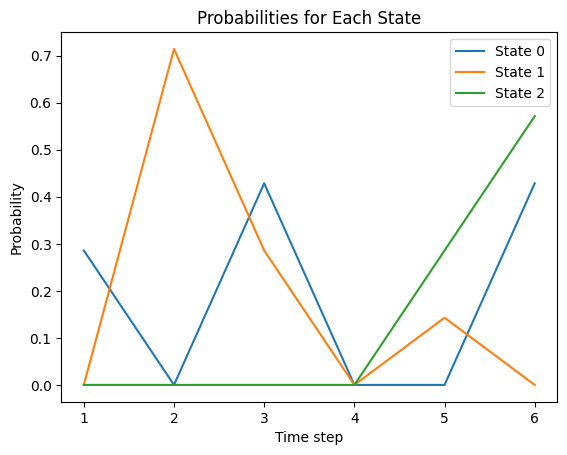

In [ ]:
def fb_alg(states, Transition, obs, q, Duration):
    T = len(obs)
    alpha = forward(states, Transition, obs, q, Duration).detach().numpy()
    beta = backward(states, Transition, obs, q, Duration).detach().numpy()
    fb_probs = alpha * beta
    
    # normalize
    fb_sum = np.sum(alpha[T-1])
    fb_probs /= fb_sum if fb_sum != 0 else 1
    
    return np.array(fb_probs)

fb_probs = fb_alg(states, Transition, obs, q, Duration)
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), probs, label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()